In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import math
import os
import folium
import geopy.distance

In [2]:
pos_df = pandas.DataFrame(
    data = [
        ["walking", "50.81652", "8.77124"],
        ["city", "50.81774", "8.77236"],
        ["rural", "50.85028", "8.90166"],
    ], 
    columns = ["scenario", "static_lat", "static_lon"], 
)

In [3]:
def load_csv(name):
    scenario, mode, iteration = name.split(".")[0].split("_")
    print(f"Loading {scenario}, mode {mode}, iteration {iteration}...")
    
    df = pandas.read_csv(name)
    df["recv_ts"] = df["unix_nanosec"] / 10**9
    df["payload"] = df.apply(lambda row: bytes.fromhex(row["payload"]).decode("utf-8"), axis=1)
    df["channel"] = df.apply(lambda row: row["payload"].split("|")[0], axis=1)
    df["sender"] = df.apply(lambda row: row["payload"].split("|")[1], axis=1)
    df["gps_lat"] = df.apply(lambda row: row["payload"].split("|")[2].split(",")[1], axis=1)
    df["gps_lon"] = df.apply(lambda row: row["payload"].split("|")[2].split(",")[0], axis=1)
    df["send_ts"] = df.apply(lambda row: int(row["payload"].split("|")[3]) / 1000, axis=1)
    df["delay_s"] = df["recv_ts"] - df["send_ts"]
    df["scenario"] = scenario
    df["mode"] = mode
    df["iteration"] = iteration
    
    return df

In [4]:
# load and merge all data
dfs = [load_csv(name) for name in os.listdir(".") if name.endswith(".csv")]
df = pandas.concat(dfs)
df = pandas.merge(df, pos_df, on="scenario", how="inner")

Loading city, mode 3, iteration 0...
Loading city, mode 3, iteration 1...
Loading city, mode 3, iteration 2...
Loading city, mode 0, iteration 1...
Loading city, mode 0, iteration 0...
Loading walking, mode 0, iteration 2...
Loading walking, mode 0, iteration 1...
Loading walking, mode 0, iteration 0...
Loading rural, mode 3, iteration 0...
Loading rural, mode 0, iteration 0...


In [5]:
# compute distances
df["distance"] = df.apply(lambda row: float(geopy.distance.distance(
        (row["gps_lat"], row["gps_lon"]),
        (row["static_lat"], row["static_lon"])
    ).km), axis=1)

In [6]:
df[(df["scenario"] == "rural") & (df["mode"] == "0")].head()

,unix_nanosec,payload,rssi,snr,recv_ts,channel,sender,gps_lat,gps_lon,send_ts,delay_s,scenario,mode,iteration,static_lat,static_lon,distance
410,1576940039423670773,"eval0|sender|8.901639149976264,50.850471349016...",-56,10,1.576940e+09,eval0,sender,50.85047134901676,8.901639149976264,1.576940e+09,0.745671,rural,0,0,50.85028,8.90166,0.021337
411,1576940054425122206,"eval0|sender|8.901673044751822,50.850309930046...",-52,9,1.576940e+09,eval0,sender,50.850309930046706,8.901673044751822,1.576940e+09,0.732122,rural,0,0,50.85028,8.90166,0.003454
412,1576940069425578433,"eval0|sender|8.901673044751822,50.850309930046...",-49,9,1.576940e+09,eval0,sender,50.850309930046706,8.901673044751822,1.576940e+09,0.733579,rural,0,0,50.85028,8.90166,0.003454
413,1576940084426011375,"eval0|sender|8.901673044751822,50.850309930046...",-49,10,1.576940e+09,eval0,sender,50.850309930046706,8.901673044751822,1.576940e+09,0.734011,rural,0,0,50.85028,8.90166,0.003454
414,1576940099426344525,"eval0|sender|8.901673044751822,50.850309930046...",-55,9,1.576940e+09,eval0,sender,50.850309930046706,8.901673044751822,1.576940e+09,0.734344,rural,0,0,50.85028,8.90166,0.003454


In [7]:
def plot_map(scen_df, db_norm=150, snr_norm=4, zoom_start=14):
    scen_pos = (scen_df.iloc[0]["static_lat"], scen_df.iloc[0]["static_lon"])
    m = folium.Map(
        scen_pos, 
        zoom_start=zoom_start, 
        tiles=None, 
        control_scale=True,
    )
    
    # add Tiles Layers
    folium.TileLayer(tiles='StamenTerrain', name="Terrain").add_to(m)
    #folium.TileLayer(tiles='OpenStreetMap', name="Streets").add_to(m)
    
    # add center marker
    folium.Marker(location=scen_pos).add_to(m)
    

    # Plot groups for modes
    for mode, mode_df in scen_df.groupby("mode"):
        if mode == "0":
            name = "Medium Range"
            color = "orange"
        elif mode == "3":
            name = "Long Range"
            color = "red"
        else:
            name = "Unknown Mode"
            color = "black"

        # get longest distance point for group
        max_dist = mode_df.iloc[mode_df['distance'].values.argmax()]
        
        # create group for mode
        group = folium.FeatureGroup(name=f'<span style=\"color: {color};\">{name}</span>').add_to(m)
        
        # add line to max distance point
        folium.PolyLine([
            (float(max_dist["static_lat"]), float(max_dist["static_lon"])),
            (float(max_dist["gps_lat"]), float(max_dist["gps_lon"])),
        ], color="black").add_to(group)
        
        # plot measurement points
        for i, row in mode_df.iterrows():
            popup = folium.map.Popup(
                html="{:.2f}&nbsp;km".format(row['distance']), 
                color="red",
                sticky=False,
                show=False,
            )
            
            # enable max distances per default
            if row.equals(max_dist):
                popup.show = True
                popup.options["autoClose"] = False
                popup.options["closeOnClick"] = False
            
            measure_details = folium.map.Tooltip(text="RSSI: {}<br>SNR: {}".format(row['rssi'], row['snr']))
            folium.CircleMarker(
                location = (row["gps_lat"], row["gps_lon"]), 
                radius = (row["rssi"] + db_norm) / db_norm * 25,
                opacity = 0.7,
                fill = True, 
                color = color, 
                tooltip = measure_details,
                popup = popup,
            ).add_to(group)
        
    # add legend
    folium.map.LayerControl('topright', name="Test", collapsed=False).add_to(m)

    return m

In [8]:
rural_map = plot_map(df[df["scenario"] == "rural"])
rural_map

In [9]:
city_map = plot_map(df[df["scenario"] == "city"], zoom_start=14)
city_map

In [10]:
def render_png(m, png_path, delay=1, width=1200, height=1000):
    from selenium import webdriver
    from folium.utilities import _tmp_html
    import time

    options = webdriver.firefox.options.Options()
    options.add_argument('--headless')
    driver = webdriver.Firefox(options=options)

    old_options = m.options
    m.options["zoomControl"] = False
    
    html = m.get_root().render()
    with _tmp_html(html) as fname:
        driver.get('file:///{path}'.format(path=fname))
        driver.set_window_size(width, height)
        time.sleep(delay)
        png = driver.get_screenshot_as_png()
        driver.quit()
    
    m.options = old_options
        
    with open(png_path, "wb") as png_file:
        png_file.write(png)

In [11]:
# export maps as html and png
rural_map.save("../gfx/rural.html")  
city_map.save("../gfx/city.html")

render_png(rural_map, "../gfx/rural.png", width=800, height=600)
render_png(city_map, "../gfx/city.png", width=800, height=1000)

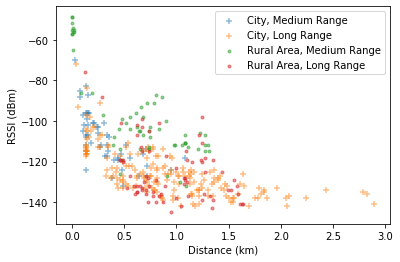

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for (scenario, mode), gdf in df.groupby(["scenario", "mode"]):
    if scenario == "walking":
        continue
    label = ('Rural Area' if scenario == 'rural' else 'City') + \
        ', ' + ("Medium Range" if mode == '0' else "Long Range")
    color = "orange" if mode == '0' else "red"
    marker = "." if scenario == "rural" else "+"
        
    ax.scatter(gdf["distance"], gdf["rssi"], label=label, alpha=0.5, marker=marker)

ax.set_xlabel("Distance (km)")
ax.set_ylabel("RSSI (dBm)")
legend = plt.legend()
fig.savefig("../gfx/rssi-distance.pdf")